In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

# Add parent directory to path to 
# allow imports of custom modules
if not '..' in sys.path:
    sys.path.append('..')
from utils.data.gen import get_toy_dataset

((100, 2), (100,))

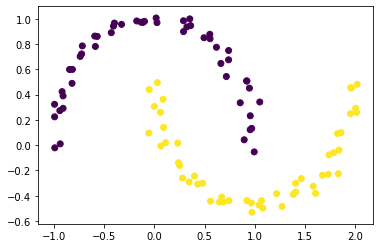

In [46]:
X, y = get_toy_dataset('moons', n_samples=100)
plt.scatter(X[:,0], X[:,1], c=y)
X.shape, y.shape

In [47]:
X = tf.convert_to_tensor(X, dtype=tf.double)
y = tf.convert_to_tensor(y, dtype=tf.double)

In [16]:
#pdist_matrix = pairwise_distance(X, squared=True)
# Reshape label tensor to [batch_size, 1].
lshape = tf.shape(y)
y = tf.reshape(y, [lshape[0], 1])
adjacency = tf.math.equal(y, tf.transpose(y))
adjacency_not = tf.math.logical_not(adjacency)
adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)

In [31]:
def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.
    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = tf.math.add(
        tf.math.reduce_sum(tf.math.square(feature), axis=[1], keepdims=True),
        tf.math.reduce_sum(
            tf.math.square(tf.transpose(feature)), axis=[0], keepdims=True
        ),
    ) - 2.0 * tf.matmul(feature, tf.transpose(feature))

    return pairwise_distances_squared
    
    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = tf.math.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = tf.math.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = tf.math.sqrt(
            pairwise_distances_squared
            + tf.cast(error_mask, dtype=tf.dtypes.float32) * 1e-16
        )

    # Undo conditionally adding 1e-16.
    pairwise_distances = tf.math.multiply(
        pairwise_distances,
        tf.cast(tf.math.logical_not(error_mask), dtype=tf.dtypes.float32),
    )

    num_data = tf.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = tf.ones_like(pairwise_distances) - tf.linalg.diag(
        tf.ones([num_data])
    )
    pairwise_distances = tf.math.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

In [120]:
def _masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.
    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the maximum.
    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = tf.math.reduce_min(data, dim, keepdims=True)
    masked_maximums = (
        tf.math.reduce_max(
            tf.math.multiply(data - axis_minimums, mask), dim, keepdims=True
        )
        + axis_minimums
    )
    return masked_maximums

In [125]:
def _masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.
    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.
    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = tf.math.reduce_max(data, dim, keepdims=True)
    masked_minimums = (
        tf.math.reduce_min(
            tf.math.multiply(data - axis_maximums, mask), dim, keepdims=True
        )
        + axis_maximums
    )
    return masked_minimums

In [126]:
def triplet_hard_loss(y_true, y_pred, margin = 1.0, soft = False):
    """Computes the triplet loss with hard negative and hard positive mining.
    Args:
      y_true: 1-D integer `Tensor` with shape [batch_size] of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      soft: Boolean, if set, use the soft margin version.
    """
    labels, embeddings = y_true, y_pred
    
    print(labels.shape, embeddings.shape)
    
    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=True)
    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)
    
    # Cast
    pdist_matrix = tf.cast(pdist_matrix, dtype=tf.dtypes.float32)
    adjacency = tf.cast(adjacency, dtype=tf.dtypes.float32)
    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    
    # hard negatives: smallest D_an.
    hard_negatives = _masked_minimum(pdist_matrix, adjacency_not)

    batch_size = tf.size(labels)
    mask_positives = adjacency - tf.linalg.diag(tf.ones([batch_size]))

    # hard positives: largest D_ap.
    hard_positives = _masked_maximum(pdist_matrix, mask_positives)

    if soft:
        triplet_loss = tf.math.log1p(tf.math.exp(hard_positives - hard_negatives))
    else:
        triplet_loss = tf.maximum(hard_positives - hard_negatives + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

In [127]:
triplet_hard_loss(y_true=y, y_pred=X)

(100,) (100, 2)


<tf.Tensor: shape=(), dtype=float32, numpy=3.8743985>